# The Music of the Sphere: Reconstruction test from mock data using SVD decomposition

*Laurence Perreault Levasseur, Phil Marshall, and Roger Blandford, January 2016*

In this notebook we generate a mock Universe and use the likelihood from Music allegro paper to reconstruct the 3D map of the interior sphere.

To do this we make use of 100 posterior sample Commander Planck CMB temperature maps to calculate the $a_lm$'s covariance matrix, and use a prior for the $f_n$'s constructed from a primordial power spectrum with amplitude given by Planck and a spectral index of 0.97. To do the reconstruction we do not use a mask on the T map and use SVD to deal with all ill-conditioned matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import beatbox
import os.path

1


In [3]:
You=beatbox.Multiverse(truncated_nmax=6, truncated_nmin=1, truncated_lmax=30, truncated_lmin=1)
beatbox.You.create_original_Universe()
beatbox.You.initiate_simulated_universe()

Generated  924  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  -0.0 +/- 1.03e-05


beatbox/universe.py:525: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


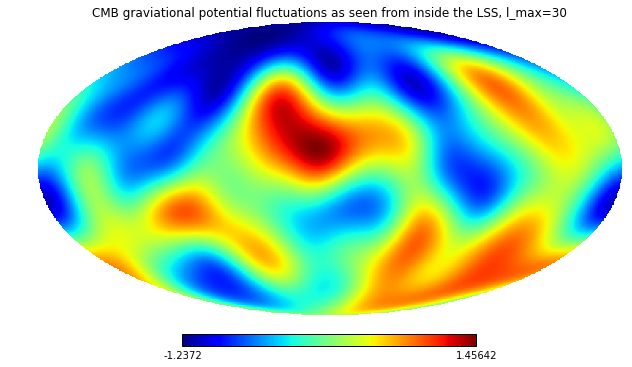

In [4]:
# Plot the generated T map
%matplotlib inline
import healpy as hp
beatbox.You.all_simulated_universes[-1].show_CMB_T_map(from_perspective_of="observer")

In [5]:
# Calculate C_yy from the 100 posterior sample Commander Planck CMB temperature maps 
#    or load the C_yy matrix if already calculated
if not os.path.isfile('data/covCyy.txt'):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix()
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax30.txt')

In [15]:
# Calculate the inverse of the a_y covariance matrix
beatbox.You.calculate_sdv_Cyy_inverse()

In [7]:
# Use the simulated Universe as mock data
# First, generate one realization of noise
#noise = beatbox.You.generate_one_realization_of_noise()
# Add the noise to the realization of the sky map
datamap=beatbox.You.all_simulated_universes[-1].ay2ayreal_for_inference(beatbox.You.all_simulated_universes[-1].ay)#+noise
#datamap=datamap.T

beatbox/universe.py:383: ComplexWarning: Casting complex values to real discards the imaginary part
  ay_real[zero_ind] = value[zero_ind].astype(np.float)


In [8]:
# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)

beatbox/multiverse.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  R_real[zero_ind,:] = beatbox.Universe.R[zero_ind,:].astype(np.float)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


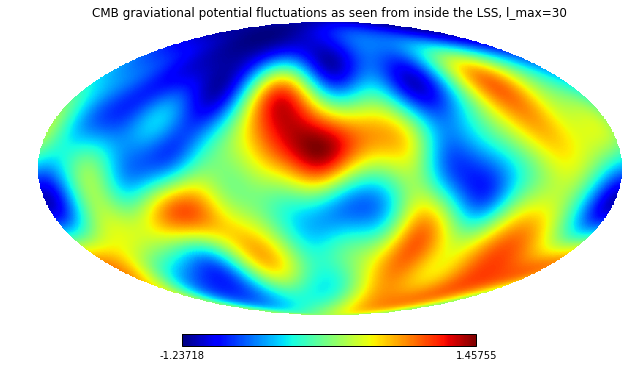

In [9]:
# Give those reconstructed f_n's to one realization of the Universe
We=beatbox.Universe()
We.fn=beatbox.You.reconstrunct_fn
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(from_perspective_of="observer")

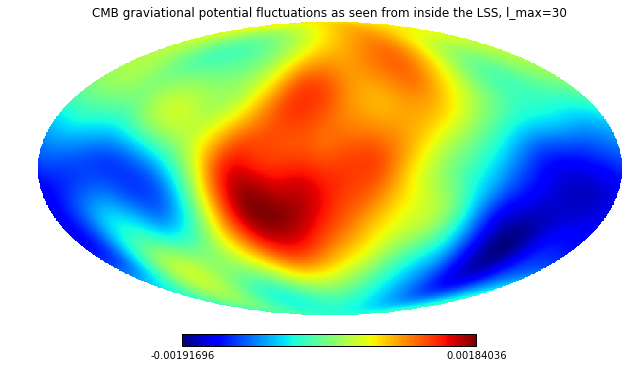

In [10]:
# Plot the residuals:
Residuals=We.Tmap-beatbox.You.all_simulated_universes[-1].Tmap
We.show_CMB_T_map(Tmap=Residuals,from_perspective_of="observer")

In [11]:
# From those f_n's build the 3d spatial potential:
ind = np.where(We.kfilter>0)
NN = 2*len(ind[1])
k_x, k_y, k_z = We.kx[ind], We.ky[ind], We.kz[ind]


RealPhi = np.zeros(We.x.shape,dtype=np.complex128)
for i in range(len(k_x)/2):
    phase = k_x[i] * We.x + k_y[i] * We.y + k_z[i] * We.z
    RealPhi += (We.fn[i] * np.cos(phase)+We.fn[len(k_x)-1-i]*np.sin(phase))*We.Deltak**3
    We.phi = RealPhi.real

yt : [INFO     ] 2016-01-22 11:49:33,964 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 11:49:33,965 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 11:49:33,967 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 11:49:33,968 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 11:49:33,969 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 11:49:34,013 Loading field plugins.
yt : [INFO     ] 2016-01-22 11:49:34,014 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 11:49:34,015 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 11:49:34,016 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 11:49:34,017 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 11:49:34,019 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 11:49:34,020 Loaded geometric (112 ne

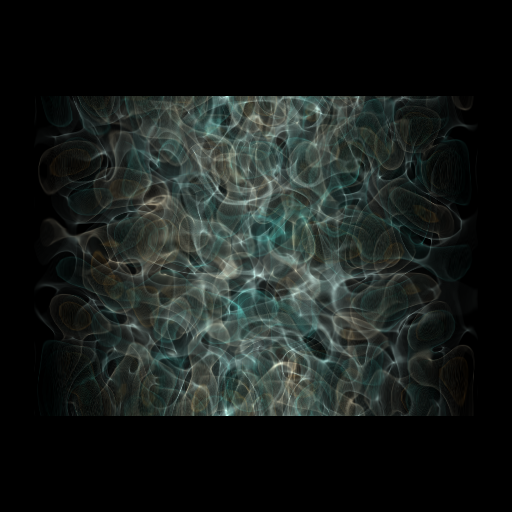

In [12]:
import yt 
We.Pdist=1
We.Pmax=2*np.pi
We.show_potential_with_yt(angle=np.pi/2,  N_layer=5, cmap='BrBG', show3D=1)

In [19]:
ind = np.where(beatbox.Universe.kfilter>0)
PS = np.zeros(2*len(ind[1]))
PS[:len(ind[1])] = (beatbox.You.all_simulated_universes[-1].Power_Spectrum[ind]/2)
PS[len(ind[1]):] = (beatbox.You.all_simulated_universes[-1].Power_Spectrum[ind]/2)

F=sum(((We.fn.reshape(len(PS),1) - beatbox.You.all_simulated_universes[-1].fn.reshape(len(PS),1))/PS.reshape(len(PS),1))**2)

In [20]:
F/len(PS)

array([ 75229.69337391])

In [13]:
We.show_potential_from_all_angles_with_yt(output='recon.gif')

yt : [INFO     ] 2016-01-22 13:05:10,908 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:10,908 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:10,909 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:10,910 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:10,911 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:10,945 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:10,945 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:10,946 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:10,947 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:10,949 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:10,950 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:10,952 Loaded geometric (112 ne

Making frame 0 :  frames/000 at viewing angle 0.785398163397
Making frame

/Users/LaurencePeanuts/miniconda2/lib/python2.7/site-packages/yt/units/yt_array.py:795: RuntimeWarning: invalid value encountered in divide
  return YTArray(super(YTArray, self).__div__(ro))
yt : [INFO     ] 2016-01-22 13:05:14,889 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:14,890 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:14,891 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:14,892 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:14,892 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:14,919 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:14,919 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:14,920 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:14,921 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016

 1 :  frames/001 at viewing angle 0.829031394697
Making frame

yt : [INFO     ] 2016-01-22 13:05:18,719 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:18,720 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:18,721 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:18,722 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:18,723 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:18,756 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:18,756 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:18,757 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:18,757 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:18,758 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:18,759 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:18,759 Loaded geometric (112 ne

 2 :  frames/002 at viewing angle 0.872664625997
Making frame

yt : [INFO     ] 2016-01-22 13:05:22,650 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:22,651 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:22,652 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:22,652 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:22,653 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:22,679 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:22,679 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:22,680 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:22,681 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:22,682 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:22,683 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:22,683 Loaded geometric (112 ne

 3 :  frames/003 at viewing angle 0.916297857297
Making frame

yt : [INFO     ] 2016-01-22 13:05:26,556 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:26,557 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:26,557 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:26,558 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:26,559 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:26,587 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:26,588 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:26,588 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:26,588 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:26,589 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:26,590 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:26,591 Loaded geometric (112 ne

 4 :  frames/004 at viewing angle 0.959931088597
Making frame

yt : [INFO     ] 2016-01-22 13:05:30,460 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:30,461 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:30,462 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:30,463 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:30,464 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:30,489 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:30,489 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:30,490 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:30,490 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:30,491 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:30,492 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:30,493 Loaded geometric (112 ne

 5 :  frames/005 at viewing angle 1.0035643199
Making frame

yt : [INFO     ] 2016-01-22 13:05:34,419 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:34,420 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:34,421 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:34,422 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:34,423 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:34,450 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:34,451 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:34,451 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:34,452 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:34,453 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:34,454 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:34,455 Loaded geometric (112 ne

 6 :  frames/006 at viewing angle 1.0471975512
Making frame

yt : [INFO     ] 2016-01-22 13:05:38,366 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:38,366 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:38,367 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:38,368 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:38,370 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:38,390 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:38,390 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:38,391 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:38,391 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:38,392 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:38,394 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:38,394 Loaded geometric (112 ne

 7 :  frames/007 at viewing angle 1.0908307825
Making frame

yt : [INFO     ] 2016-01-22 13:05:43,010 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:43,010 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:43,011 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:43,012 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:43,013 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:43,032 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:43,033 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:43,033 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:43,034 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:43,035 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:43,036 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:43,037 Loaded geometric (112 ne

 8 :  frames/008 at viewing angle 1.1344640138
Making frame

yt : [INFO     ] 2016-01-22 13:05:46,604 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:46,604 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:46,605 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:46,606 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:46,607 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:46,626 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:46,626 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:46,627 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:46,627 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:46,628 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:46,630 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:46,630 Loaded geometric (112 ne

 9 :  frames/009 at viewing angle 1.1780972451
Making frame

yt : [INFO     ] 2016-01-22 13:05:50,307 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:50,307 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:50,308 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:50,309 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:50,310 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:50,332 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:50,333 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:50,334 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:50,335 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:50,337 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:50,338 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:50,339 Loaded geometric (112 ne

 10 :  frames/010 at viewing angle 1.2217304764
Making frame

yt : [INFO     ] 2016-01-22 13:05:54,360 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:54,360 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:54,361 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:54,362 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:54,364 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:54,388 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:54,389 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:54,389 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:54,390 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:54,391 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:54,392 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:54,393 Loaded geometric (112 ne

 11 :  frames/011 at viewing angle 1.2653637077
Making frame

yt : [INFO     ] 2016-01-22 13:05:58,482 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:05:58,482 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:05:58,483 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:05:58,484 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:05:58,485 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:05:58,508 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:05:58,508 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:05:58,509 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:05:58,510 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:05:58,511 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:05:58,512 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:05:58,513 Loaded geometric (112 ne

 12 :  frames/012 at viewing angle 1.308996939
Making frame

yt : [INFO     ] 2016-01-22 13:06:02,781 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:02,781 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:02,782 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:02,785 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:02,787 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:02,826 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:02,827 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:02,828 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:02,828 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:02,829 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:02,830 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:02,830 Loaded geometric (112 ne

 13 :  frames/013 at viewing angle 1.3526301703
Making frame

yt : [INFO     ] 2016-01-22 13:06:06,824 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:06,824 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:06,825 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:06,826 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:06,827 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:06,848 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:06,849 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:06,849 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:06,850 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:06,852 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:06,853 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:06,854 Loaded geometric (112 ne

 14 :  frames/014 at viewing angle 1.3962634016
Making frame

yt : [INFO     ] 2016-01-22 13:06:11,332 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:11,333 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:11,334 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:11,335 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:11,336 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:11,367 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:11,368 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:11,369 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:11,369 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:11,371 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:11,372 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:11,373 Loaded geometric (112 ne

 15 :  frames/015 at viewing angle 1.4398966329
Making frame

yt : [INFO     ] 2016-01-22 13:06:15,044 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:15,045 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:15,045 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:15,046 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:15,047 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:15,076 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:15,076 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:15,077 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:15,078 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:15,079 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:15,080 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:15,081 Loaded geometric (112 ne

 16 :  frames/016 at viewing angle 1.4835298642
Making frame

yt : [INFO     ] 2016-01-22 13:06:18,648 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:18,648 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:18,649 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:18,649 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:18,650 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:18,669 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:18,669 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:18,670 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:18,670 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:18,671 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:18,672 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:18,673 Loaded geometric (112 ne

 17 :  frames/017 at viewing angle 1.5271630955
Making frame

yt : [INFO     ] 2016-01-22 13:06:22,199 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:22,199 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:22,201 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:22,202 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:22,203 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:22,222 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:22,223 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:22,223 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:22,224 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:22,225 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:22,226 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:22,226 Loaded geometric (112 ne

 18 :  frames/018 at viewing angle 1.57079632679
Making frame

yt : [INFO     ] 2016-01-22 13:06:26,805 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:26,807 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:26,810 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:26,812 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:26,813 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:26,836 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:26,836 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:26,837 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:26,838 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:26,838 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:26,840 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:26,840 Loaded geometric (112 ne

 19 :  frames/019 at viewing angle 1.61442955809
Making frame

yt : [INFO     ] 2016-01-22 13:06:30,550 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:30,551 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:30,552 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:30,553 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:30,553 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:30,573 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:30,573 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:30,574 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:30,574 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:30,575 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:30,577 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:30,577 Loaded geometric (112 ne

 20 :  frames/020 at viewing angle 1.65806278939
Making frame

yt : [INFO     ] 2016-01-22 13:06:34,190 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:34,190 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:34,191 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:34,193 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:34,194 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:34,223 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:34,224 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:34,224 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:34,225 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:34,227 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:34,228 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:34,229 Loaded geometric (112 ne

 21 :  frames/021 at viewing angle 1.70169602069
Making frame

yt : [INFO     ] 2016-01-22 13:06:37,876 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:37,877 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:37,877 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:37,879 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:37,880 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:37,901 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:37,902 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:37,902 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:37,903 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:37,914 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:37,916 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:37,917 Loaded geometric (112 ne

 22 :  frames/022 at viewing angle 1.74532925199
Making frame

yt : [INFO     ] 2016-01-22 13:06:41,723 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:41,724 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:41,724 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:41,725 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:41,726 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:41,752 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:41,753 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:41,753 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:41,754 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:41,755 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:41,756 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:41,756 Loaded geometric (112 ne

 23 :  frames/023 at viewing angle 1.78896248329
Making frame

yt : [INFO     ] 2016-01-22 13:06:45,787 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:45,788 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:45,789 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:45,790 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:45,791 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:45,811 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:45,812 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:45,812 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:45,813 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:45,814 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:45,816 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:45,817 Loaded geometric (112 ne

 24 :  frames/024 at viewing angle 1.83259571459
Making frame

yt : [INFO     ] 2016-01-22 13:06:49,591 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:49,592 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:49,592 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:49,593 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:49,594 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:49,623 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:49,624 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:49,624 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:49,625 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:49,625 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:49,627 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:49,627 Loaded geometric (112 ne

 25 :  frames/025 at viewing angle 1.87622894589
Making frame

yt : [INFO     ] 2016-01-22 13:06:53,950 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:53,952 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:53,955 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:53,957 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:53,959 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:54,005 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:54,006 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:54,006 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:54,007 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:54,009 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:54,010 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:54,010 Loaded geometric (112 ne

 26 :  frames/026 at viewing angle 1.91986217719
Making frame

yt : [INFO     ] 2016-01-22 13:06:58,632 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:06:58,633 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:06:58,633 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:06:58,634 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:06:58,635 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:06:58,656 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:06:58,656 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:06:58,657 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:06:58,657 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:06:58,659 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:06:58,660 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:06:58,661 Loaded geometric (112 ne

 27 :  frames/027 at viewing angle 1.96349540849
Making frame

yt : [INFO     ] 2016-01-22 13:07:02,392 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:02,393 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:02,393 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:02,394 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:02,395 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:02,427 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:02,427 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:02,428 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:02,429 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:02,691 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:02,692 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:02,693 Loaded geometric (112 ne

 28 :  frames/028 at viewing angle 2.00712863979
Making frame

yt : [INFO     ] 2016-01-22 13:07:07,226 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:07,227 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:07,227 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:07,228 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:07,229 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:07,250 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:07,250 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:07,251 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:07,251 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:07,253 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:07,254 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:07,254 Loaded geometric (112 ne

 29 :  frames/029 at viewing angle 2.05076187109
Making frame

yt : [INFO     ] 2016-01-22 13:07:11,034 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:11,034 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:11,035 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:11,036 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:11,037 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:11,059 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:11,059 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:11,060 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:11,060 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:11,061 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:11,062 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:11,063 Loaded geometric (112 ne

 30 :  frames/030 at viewing angle 2.09439510239
Making frame

yt : [INFO     ] 2016-01-22 13:07:14,925 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:14,925 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:14,926 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:14,927 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:14,928 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:14,948 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:14,949 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:14,949 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:14,950 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:14,951 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:14,952 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:14,953 Loaded geometric (112 ne

 31 :  frames/031 at viewing angle 2.13802833369
Making frame

yt : [INFO     ] 2016-01-22 13:07:18,646 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:18,646 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:18,647 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:18,648 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:18,649 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:18,669 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:18,670 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:18,670 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:18,671 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:18,672 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:18,673 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:18,674 Loaded geometric (112 ne

 32 :  frames/032 at viewing angle 2.18166156499
Making frame

yt : [INFO     ] 2016-01-22 13:07:22,649 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:22,649 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:22,649 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:22,650 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:22,651 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:22,675 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:22,676 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:22,676 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:22,677 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:22,678 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:22,679 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:22,680 Loaded geometric (112 ne

 33 :  frames/033 at viewing angle 2.22529479629
Making frame

yt : [INFO     ] 2016-01-22 13:07:26,587 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:26,587 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:26,588 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:26,589 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:26,590 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:26,612 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:26,613 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:26,614 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:26,615 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:26,616 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:26,617 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:26,618 Loaded geometric (112 ne

 34 :  frames/034 at viewing angle 2.26892802759
Making frame

yt : [INFO     ] 2016-01-22 13:07:30,561 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-22 13:07:30,562 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-22 13:07:30,562 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-22 13:07:30,563 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-22 13:07:30,564 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-22 13:07:30,585 Loading field plugins.
yt : [INFO     ] 2016-01-22 13:07:30,586 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-22 13:07:30,586 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-22 13:07:30,587 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-22 13:07:30,588 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-22 13:07:30,589 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-22 13:07:30,589 Loaded geometric (112 ne

 35 :  frames/035 at viewing angle 2.31256125889
